<a href="https://colab.research.google.com/github/GSaiLahari/BirdsVsDrones/blob/main/BvDTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/test.zip

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
datadir = '/content/drone_or_bird'
from torch.autograd import Variable
model = torch.load('/content/drive/MyDrive/model.pth')
model.eval()
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
test_data = datasets.ImageFolder(datadir, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, shuffle=True)

In [4]:
testloader.dataset.classes

['birds', 'drones']

In [5]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(datadir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels

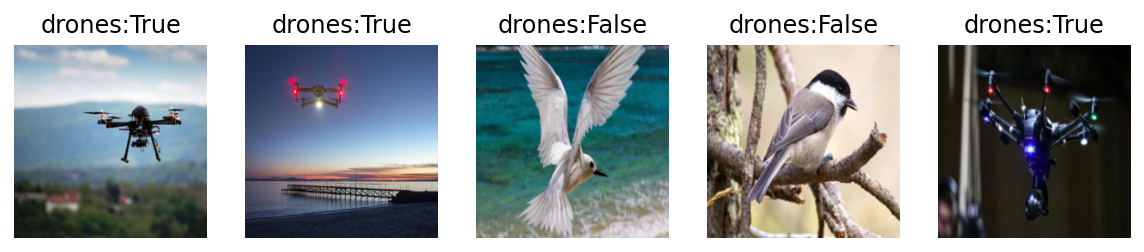

In [6]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

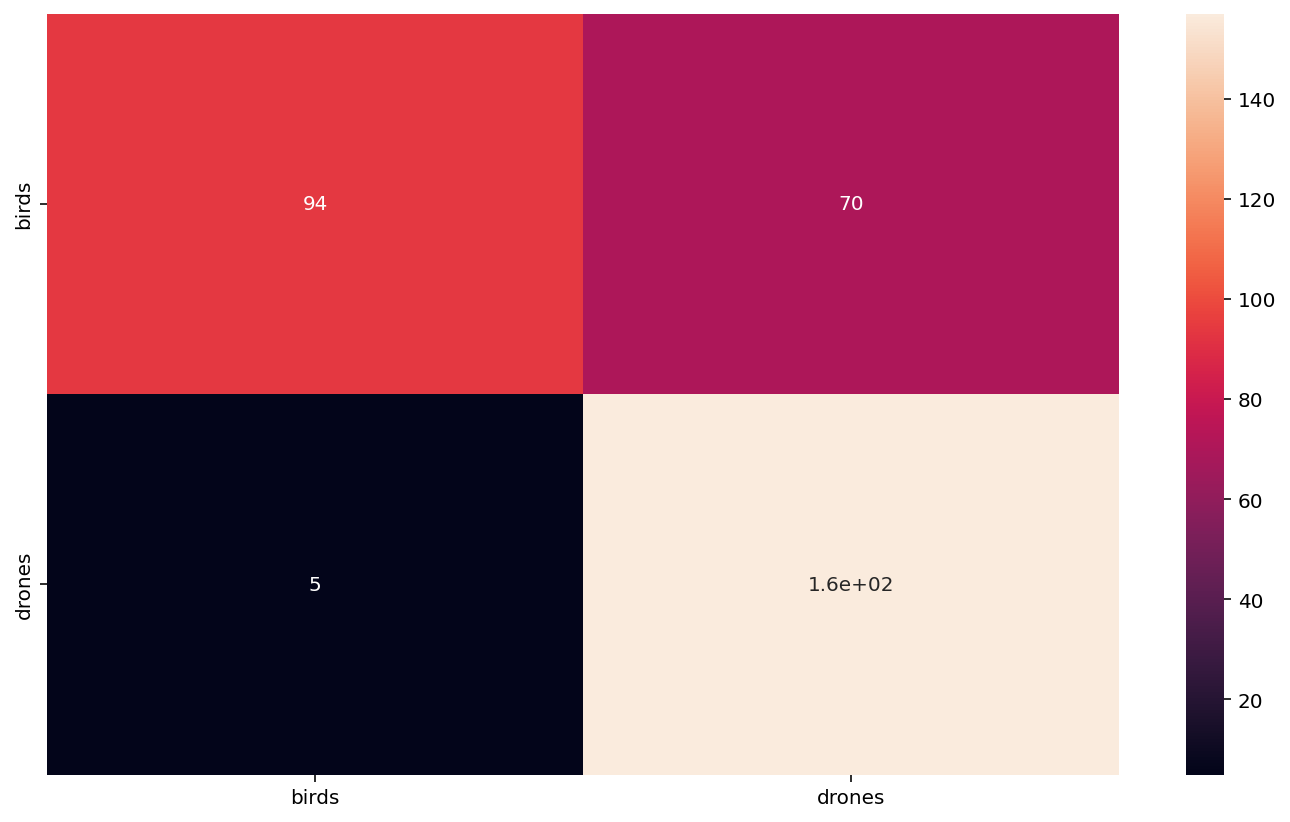

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = testloader.dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')